In [1]:
import time; start_time=time.time()

In [2]:
import numpy as np
import pandas as pd
from sklearn import ensemble
import xgboost as xgb
from sklearn.metrics import log_loss,make_scorer
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
import random; random.seed(2016)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
#Number of rows in training data
num_train = train.shape[0]

In [5]:
#Save target from train in another series and Drop the target variable 
y_train = train['target']
train = train.drop('target', axis=1)
id_test = test['ID']

In [6]:
#Merge the train and test data to perform operations on the data
df_all = pd.concat((train,test),axis=0,ignore_index=True)
df_all['null_count'] = df_all.isnull().sum(axis=1).tolist()


In [7]:
#Drop the ids
df_all_temp = df_all['ID']
df_all = df_all.drop('ID', axis=1)
d_col_drops = []

In [8]:
def fill_nan_null(val):
    ret_fill_nan_null = 0.0
    if val==True:
        ret_fill_nan_null = 1.0
    return ret_fill_nan_null

In [9]:
# Function to convert to hexavigesimal base..Special treamtement to v22
def az_to_int(az,nanVal=None):
    if az==az:  #catch NaN
        hv = 0
        for i in range(len(az)):
            hv += (ord(az[i].lower())-ord('a')+1)*26**(len(az)-1-i)
        return hv
    else:
        if nanVal is not None:
            return nanVal
        else:
            return az

# convert v22 to hexavigesimal
df_all['v22'] = df_all.v22.apply(az_to_int)

In [10]:
df_data_types = df_all.dtypes[:]
for i in range(len(df_data_types)):
    df_all[str(df_data_types.index[i])+'_nan_'] = df_all[str(df_data_types.index[i])].map(lambda x:fill_nan_null(pd.isnull(x)))

In [11]:
df_all = df_all.fillna(-99)

In [12]:
for i in range(len(df_data_types)):
    if(str(df_data_types[i]) == 'object'):
        df_u = pd.unique(df_all[str(df_data_types.index[i])].ravel())
        print("Column: ", str(df_data_types.index[i]), " Length: ", len(df_u))
        d={}
        df_all[str(df_data_types.index[i])], tmpItter = df_all[str(df_data_types.index[i])].factorize()
        d_col_drops.append(str(df_data_types.index[i]))
        if len(df_u)<150:
            dummies = pd.get_dummies(df_all[str(df_data_types.index[i])],prefix=str(df_data_types.index[i])) 
            #.rename(columns = lambda x: str(df_data_types.index[i])+str(x))
            df_all_temp = pd.concat([df_all_temp,dummies], axis=1)

Column:  v3  Length:  4
Column:  v24  Length:  5
Column:  v30  Length:  8
Column:  v31  Length:  4
Column:  v47  Length:  10
Column:  v52  Length:  13
Column:  v56  Length:  131
Column:  v66  Length:  3
Column:  v71  Length:  12
Column:  v74  Length:  3
Column:  v75  Length:  4
Column:  v79  Length:  18
Column:  v91  Length:  8
Column:  v107  Length:  8
Column:  v110  Length:  3
Column:  v112  Length:  23
Column:  v113  Length:  38
Column:  v125  Length:  91


In [13]:
df_all_temp = df_all_temp.drop('ID',axis=1)
df_all = pd.concat([df_all,df_all_temp], axis=1)
print(len(df_all),len(df_all.columns))

228714 650


In [14]:
#Just in case, we need to start all the things over again
#df_all.to_csv("df_all.csv")

In [15]:
d_col_drops

['v3',
 'v24',
 'v30',
 'v31',
 'v47',
 'v52',
 'v56',
 'v66',
 'v71',
 'v74',
 'v75',
 'v79',
 'v91',
 'v107',
 'v110',
 'v112',
 'v113',
 'v125']

In [16]:
partialDataTrain = round(num_train *0.1)

In [17]:
#Seperate out train and test data to run the model
train = df_all.iloc[:num_train]
#train = df_all.iloc[:partialDataTrain]
#y_train = y_train[:partialDataTrain]
test = df_all.iloc[num_train:]
train = train.drop(d_col_drops,axis=1)
test = test.drop(d_col_drops,axis=1)

In [18]:
def flog_loss(ground_truth,predictions):
    flog_loss_ = log_loss(ground_truth,predictions)
    return flog_loss_

LL = make_scorer(flog_loss, greater_is_better=False)

In [19]:
#g={'ne':150,'md':6,'mf':80,'rs':2016} 
#Suggested one 
g={'ne':500,'md':40,'mf':60,'rs':2016}
etc = ensemble.ExtraTreesClassifier(n_estimators=g['ne'], max_depth=g['md'], max_features=g['mf'], 
                                    random_state=g['rs'], criterion='entropy', min_samples_split= 4, 
                                    min_samples_leaf= 2, verbose = 0, n_jobs =-1)

etr = ensemble.ExtraTreesRegressor(n_estimators=g['ne'], max_depth=g['md'], max_features=g['mf'], 
                                   random_state=g['rs'], min_samples_split= 4, min_samples_leaf= 2,
                                   verbose = 0, n_jobs =-1)    


In [20]:
clf = {'etc':etc, 'etr':etr} # use this line instead
# removed due to kaggle performance, would prefer less time and more cores than more time and less cores :)
#clf = {'etr':etr, 'rfr':rfr, 'xgr':xgr}
#Since i am getting a pickling error, we moved to only xgb regressor and classifier
#clf = {'xgr':xgr,'xgc':xgc}

In [21]:
y_pred=[]
best_score = 0.0
id_results = id_test[:]

In [22]:
param_dist = {
    'n_estimators': list(range(250,300,10)),
    'max_depth' : list(range(20,60,10)),
    'max_features' : list(range(20,100,10)),
    'max_leaf_nodes' : list(range(5,20)),
    'min_samples_leaf' : list(range(1,5)),
    'min_samples_split' : list(range(2,10))    
}

In [23]:
#Do some Radomized search CV and find ou the best possible parameters in each case
random_search = RandomizedSearchCV(clf['etc'], param_distributions=param_dist,n_iter=20, scoring=LL,
                                   n_jobs=1, iid=True, refit=True, cv=2, verbose=1)

In [24]:
random_search.fit(train,y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 14.1min finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=40, max_features=60, max_leaf_nodes=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=2016, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [20, 30, 40, 50], 'max_features': [20, 30, 40, 50, 60, 70, 80, 90], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'n_estimators': [250, 260, 270, 280, 290], 'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(flog_loss, greater_is_better=False),
          verbose=1)

In [25]:
random_search.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=50, max_features=50, max_leaf_nodes=14,
           min_samples_leaf=3, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=270, n_jobs=-1,
           oob_score=False, random_state=2016, verbose=0, warm_start=False)

In [35]:
classifier = ensemble.ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=50, max_features=50, max_leaf_nodes=14,
           min_samples_leaf=3, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=270, n_jobs=-1,
           oob_score=False, random_state=2016, verbose=0, warm_start=False)

In [36]:
classifier.fit(train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=50, max_features=50, max_leaf_nodes=14,
           min_samples_leaf=3, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=270, n_jobs=-1,
           oob_score=False, random_state=2016, verbose=0, warm_start=False)

In [37]:
imp = pd.DataFrame({'col' : train.columns.values, 'imp':classifier.feature_importances_})

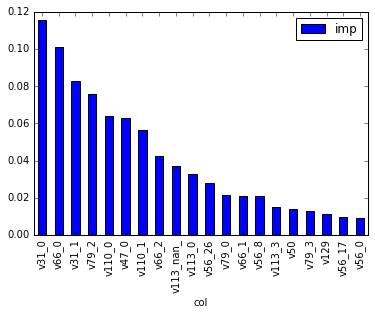

In [38]:
%matplotlib inline
imp.sort_values('imp',ascending=False).head(20).plot(kind='bar',x='col',y='imp')

In [39]:
probabities = classifier.predict_proba(test)

In [40]:
prob = pd.DataFrame(probabities[:,1])

In [41]:
type(probabities[:,1])

numpy.ndarray

In [42]:
id_results = pd.DataFrame({"ID": id_test, 'PredictedProb': probabities[:,1]})

In [43]:
id_results.to_csv('ext_classifier.csv',index=False)